# Problem

### You have to read the both datasets such that.
1) The result is one final pandas dataframe having records from both the datasets.
2) The dataframe should have two columns: Text & Sentiment.

### Now perform the following NLP methods on the Text column in this order:
1) Remove all HTML characters in the data. 

2) Remove all website links from the data of form www.xyz.com

3) Convert major emoticons to their respective emoticons such as, '😊' to    ‘happy’, '😔' to 'sad', '🤣' to 'laugh'.

4) Remove all punctuations except fullstop(.), exclamation (!) and comma (,).

5) Remove major stopwords.

6) Lemmatize all the words.

7) Tokenize the data.

8) Finally, convert the data into vector forms using Word2Vec with vector size of 20.

# Import 

In [1]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import pandas_profiling
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# Reading the data

In [2]:
data1 = pd.read_csv('Round1_Problem1-of-2_Dataset_amazon_cells_labelled.txt', sep = '\t', header = None, names = ['Text', 'Sentiment'])
data2 = pd.read_csv('Round1_Problem1-of-2_Dataset_imdb_labelled.txt', sep = '\t', header = None, names = ['Text', 'Sentiment'])

# Combining the two text files to one single data frame.
df = pd.concat([data1, data2])
# Resetting the index.
df = df.reset_index()
# Dropping the index column
df = df.drop(['index'], axis = 1)

# lowercasing the data.
df.loc[:,'Text'] = df.Text.apply(lambda x: str.lower(x))

In [3]:
df.head(10)

,Text,Sentiment
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1
5,i have to jiggle the plug to get it to line up...,0
6,if you have several dozen or several hundred c...,0
7,if you are razr owner...you must have this!,1
8,"needless to say, i wasted my money.",0
9,what a waste of money and time!.,0


In [4]:
# Inorder to access the report.
# First you have to install pandas profiling. Remove the comment below.
#!pip install pandas_profiling

In [5]:
# After that import the library. Remove the comment below and run the cell.
#import pandas_profiling

df.profile_report()

# 1) Remove HTML Characters


In [6]:
def remove_html_tags(text):
    'This removes all the html tags in the text'
    soup = BeautifulSoup(text, 'html.parser')
    stripped_html = soup.get_text()
    return stripped_html

# Appling the above function to remove the html charactes 
df.loc[:,'Text'] = df.Text.apply(lambda x: remove_html_tags(x))

# 2) Remove Website Links (www.xyz.com)


In [7]:
# The regex generated to find the links is ---> (www\.[A-za-z-]{2,256}\.[a-z]{2,6})([-a-zA-Z0-9@:%_\+.~#?&//=]*)

# Compiling the expression with re
w = re.compile(r'(www\.[A-za-z-]{2,256}\.[a-z]{2,6})([-a-zA-Z0-9@:%_\+.~#?&//=]*)')

# Defining a function to find and remove the links
def remove_www(text):
    return w.sub('', text)

# Applying the above function to the text column.
df.loc[:,'Text'] = df.Text.apply(lambda x: remove_www(x))

# 3) This is to find the no of the emoticons. 
#### (There are absolutely zero emoticons in the whole dataset)


In [8]:
# This gives the name of the emoticon found. 

from emoji.unicode_codes import UNICODE_EMOJI
emoji = '😊'
print(UNICODE_EMOJI[emoji]) 

# This gives the name of the emoticon found. 

# In order to name the emoticon you can create a list of entire emojis and get the corresponding texts using the above method, 
# and then store the (emoji, text) as a dictionary.


:smiling_face_with_smiling_eyes:


In [9]:
# Convert major emoticons to their respective emotions such as, Jto ‘happy’, Lto ‘sad’, :D to ‘laugh’
emoji = re.compile(r'[😊]|[😔]|[🤣]')

# Defining a function to find emoticons.
def find_emo(text):
    return re.findall(emoji, text)

# It returns nothing because there are no emoticons. 
d = df.Text.apply(lambda x: find_emo(x)) 

# 4) Removing Punctuations except '.', '!', ','


In [10]:
# Compiling the expression with re
p = re.compile(r'[@#$:)(;?&/\-]') 

# Defining to remove punctuations
def remove_punt(text):
    return p.sub('', text)
                     
# Applying the above function to the text column.
df.loc[:,'Text'] = df.Text.apply(lambda x: remove_punt(x))

# 5) Removing major Stop Words


In [11]:
# Importing stop_words
from stop_words import get_stop_words
stop_words = get_stop_words('english')

# Defining a function to remove the stop words found.
def remove_stopWords(s):
    
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

# Applying the above function to text column.
df.loc[:,'Text'] = df.Text.apply(lambda x: remove_stopWords(x))

# 6) Lemmatizing


In [12]:
# importing WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer

# Storing the fucntion call to wnl
wnl = WordNetLemmatizer()

# Applying the lemmatizer to the text column
df.loc[:,'Text'] = df.Text.apply(lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]))

# 7) Tokenize


In [13]:
# We are using nltk's word tokenizer to tokenize the text column
df.loc[:,'Text'] = df.Text.apply(lambda x: nltk.word_tokenize(x))

In [14]:
df.Text[5]

['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume', '.']

# 8) Finally, convert the data into vector forms using Word2Vec with vector size of 20.

### Important Libraries

In [15]:
import gensim
import tqdm
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

## Skip Gram Method


- size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
- window: (default 5) The maximum distance between a target word and words around the target word.
- min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
- workers: (default 3) The number of threads to use while training.
- sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).


In [16]:
# training the model
skipgram = Word2Vec(df.loc[:,'Text'], size = 20, window = 3, min_count=5,sg = 1)

In [17]:
print(skipgram)

Word2Vec(vocab=536, size=20, alpha=0.025)


In [18]:
# access vector for one word
print(skipgram['great'])

[-0.10763165  0.2160082  -0.47445306 -0.09060933  0.19103535  0.08048625
 -0.19400617  0.6139545   0.23629287 -0.22484864 -0.24560025  0.32521224
 -0.45981565  0.07720182 -0.5614648   0.14337538  0.12780221  0.17802899
  0.09472479 -0.05080701]


In [19]:
# Save the model
skipgram.save('skipgram.bin')

In [20]:
# Load the model
skipgram = Word2Vec.load('skipgram.bin')

### T – SNE plot is one of the ways to evaluate word embeddings. Let’s generate it and see how it looks.


In [21]:
# T – SNE plot
X = skipgram[skipgram.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

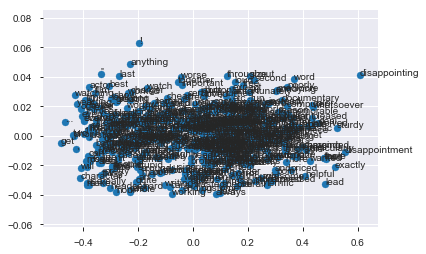

In [22]:
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
# Complete list of vocab
words = list(skipgram.wv.vocab) 
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

## CBOW Method (Continous Bag Of Words)

In [23]:
# training the model
cbow = Word2Vec(df.loc[:,'Text'], size = 20, window = 3, min_count=5, sg = 0)

In [24]:
print(cbow)

Word2Vec(vocab=536, size=20, alpha=0.025)


In [25]:
# access vector for one word
print(cbow['great'])

[-0.25823805  0.31829113 -0.45774665 -0.0267892   0.05881043  0.1365679
  0.07423391  0.6545642   0.2586656  -0.18180555 -0.3613974   0.5358858
 -0.57552177  0.1893117  -0.5197851  -0.07601961 -0.24706952  0.21437593
 -0.02292208 -0.23272088]


In [26]:
# save model
cbow.save('cbow.bin')

In [27]:
# load model
cbow = Word2Vec.load('cbow.bin')

In [28]:
# T – SNE plot
X = cbow[cbow.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

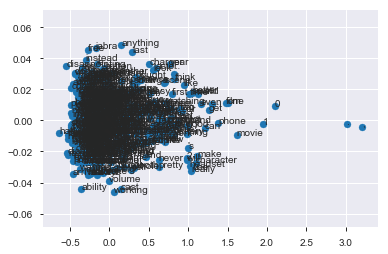

In [29]:
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(cbow.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

# Thank you.